Human model avg acc: 75.09
Ortholog avg. acc. (human): 79.89
Pct. ortholog human 15%: 0.818385470837667
Pct. genes human 15%: 0.8972432432432432
Mouse model avg acc: 71.53
Ortholog avg. acc. (mouse): 78.07
Pct. ortholog mouse 15%: 0.7967224966863478
Pct. genes mouse 15%: 0.9399705515913467
Status plot created


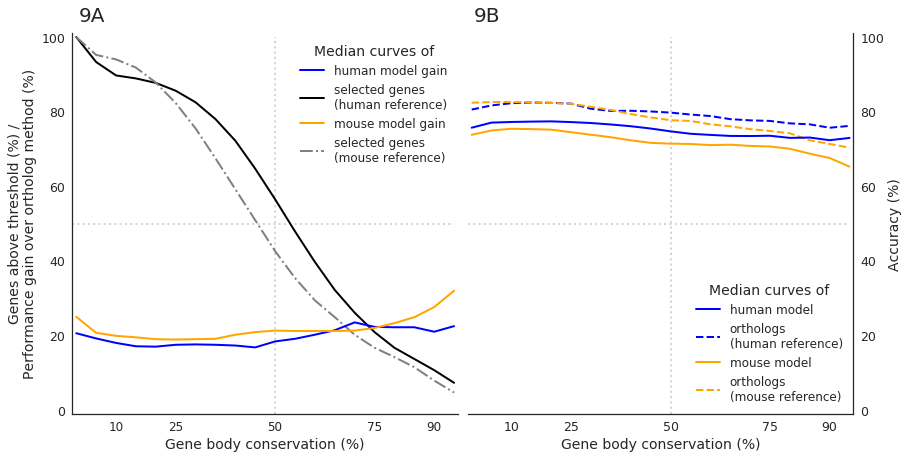

In [12]:
%matplotlib inline

import os as os
import numpy as np
import numpy.random as rng
import json as js
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu

# What is this?
# Plot model performance evaluated
# on gene subsets selected by gene
# locus conservation

date = '20180703'

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
stat_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_summarize')
stat_file = os.path.join(stat_folder, 'agg_expstat_est.h5')
ortho_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_ortho_pred')
ortho_pred = os.path.join(ortho_folder, 'orthopred_odb_v9.h5')

cache_dir = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/caching/notebooks')

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))

run_exec_status = True

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
save_figures = False

def exec_status():
    cache_data = os.path.join(cache_dir, '{}_plot_perfcomp_aln-rank.pck'.format(date))
    fullmodel = 'can'
    if not run_exec_status:
        return False
    if os.path.isfile(cache_data):
        model_perf = pck.load(open(cache_data, 'rb'))
    else:
        model_perf = collect_ortho_perf(ortho_pred, fullmodel)
        model_perf = collect_model_stat_perf(stat_file, model_perf, 'pos', fullmodel)
        with open(cache_data, 'wb') as out:
            print('Writing cache file for status line plot')
            pck.dump(model_perf, out)
    # mental note
    #bins = np.arange(0, 105, 5)
    #bins[-1] += 1
    #bin_idx = [(i, b) for i, b in enumerate(bins)]
    idx_0 = 0
    idx_50 = 10
    idx_90 = 18
    figure_keys = {'human': ('9', 'main', 'S6A'),
                   'mouse': ('S5', 'supp', 'S6B')}
    
    
    data_collect = {'human': dict(),
                    'mouse': dict()}
    
    for target in ['human', 'mouse']:
        
        gain = []
        model = []
        ortho = []
        suborth = []
        submodel = []
        genes = []
        for (t, q), perf in model_perf.items():
            if t != target:
                continue
            ortho_true = perf['data_orth_pair']['positives']
            model_true = perf['data_crp_{}_wg'.format(fullmodel)]['positives']
                        
            all_genes = perf['data_crp_{}_wg'.format(fullmodel)]['relevant'].copy()
            total_genes = all_genes.at[0, 0]

            surplus = (model_true / ortho_true).round(3)
            surplus *= 100
            surplus -= 100
            gain.append(surplus)
            
            tmp = perf['data_crp_{}_wg'.format(fullmodel)]['relevant'].copy()
            tmp /= total_genes
            
            ortho.append(perf['data_orth_pair']['accuracy'])
            model.append(perf['data_crp_{}_wg'.format(fullmodel)]['accuracy'])
            genes.append(tmp)
            
            tmp2 = perf['data_orth_pair']['relevant'].div(all_genes)
            suborth.append(tmp2)
            
            tmp3 = model_true.div(all_genes)
            submodel.append(tmp3)
        
        data_collect[target]['gain'] = pd.concat(gain, axis=0, ignore_index=False)
        data_collect[target]['ortho'] = pd.concat(ortho, axis=0, ignore_index=False)
        data_collect[target]['model'] = pd.concat(model, axis=0, ignore_index=False)
        data_collect[target]['genes'] = pd.concat(genes, axis=0, ignore_index=False)
        data_collect[target]['suborth'] = pd.concat(suborth, axis=0, ignore_index=False)
        data_collect[target]['submodel'] = pd.concat(submodel, axis=0, ignore_index=False)
    fkey = '9'
    fig, exart = plot_perf_linechart(data_collect, fkey)
    
    if save_figures:
        outname = 'fig_{}AB_perfgain_aln-rank'.format(fkey)
        subfolder = 'main'

        outpath = os.path.join(out_folder, subfolder, 'raw', outname + '.svg')
        fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')

        outpath = os.path.join(out_folder, subfolder, 'png', outname + '.png')
        fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=350)

        outpath = os.path.join(out_folder, subfolder, outname + '.pdf')
        fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
                        
    return True
       

def plot_perf_linechart(data, fkey):
    """
    """    
    fig, (ax_gain, ax_acc) = plt.subplots(figsize=(14, 7),
                                          nrows=1, ncols=2)
    
    plt.subplots_adjust(wspace=0.025)
    
    x_vals = np.arange(0, 100, 5, dtype=np.int16)
    x_ticks = np.array([10, 25, 50, 75, 90], dtype=np.int16)
    x_ticklabels = ['10', '25', '50', '75', '90']
    
    # =======================================
    # plot model performance gain
    ax_gain.set_xlim(-1, x_vals.max() + 1)
    ax_gain.set_ylim(-1, 101)
    
    ax_gain.set_xticks(x_ticks)
    ax_gain.set_xticklabels(x_ticklabels, fontsize=12)

    # plot human data
    hsa_data = data['human']
    avg_gain = hsa_data['gain'].median(axis=0).round(1)
    avg_genes = (hsa_data['genes'].median(axis=0) * 100).round(1)
           
    ax_gain.plot(x_vals, avg_gain,
                 lw=2, ls='solid', c='blue',
                 zorder=3, label='human model gain')
    
    ax_gain.plot(x_vals, avg_genes,
                 lw=2, ls='solid', c='black',
                 zorder=1, label='selected genes\n(human reference)')
    
    # plot mouse data
    mmu_data = data['mouse']
    avg_gain = mmu_data['gain'].median(axis=0).round(1)
    avg_genes = (mmu_data['genes'].median(axis=0) * 100).round(1)
       
    ax_gain.plot(x_vals, avg_gain,
                 lw=2, ls='solid', c='orange',
                 zorder=3, label='mouse model gain')
    
    ax_gain.plot(x_vals, avg_genes,
                 lw=2, ls='-.', c='grey',
                 zorder=1, label='selected genes\n(mouse reference)')
    
    leg = ax_gain.legend(loc='upper right', fontsize=12, title='Median curves of')
    leg.get_title().set_fontsize(14)
    
    ax_gain.set_xlabel('Gene body conservation (%)', fontsize=14)
    ax_gain.set_ylabel('Genes above threshold (%) /\nPerformance gain over ortholog method (%)',
                        fontsize=14)
    
    ax_gain.spines['top'].set_visible(False)
    ax_gain.spines['right'].set_visible(False)
    
    tt = ax_gain.set_title('{}A'.format(fkey), fontsize=20)
    tt.set_position((0.05, 1.015))
    
    ax_gain.axhline(50, 0, 0.99, color='lightgrey', zorder=0, lw=2, ls='dotted')
    ax_gain.axvline(50, 0, 0.99, color='lightgrey', zorder=0, lw=2, ls='dotted')
    
    # =================
    # print accuracy values for paper
    med_acc = np.round(hsa_data['model'].median(axis=0).median() * 100, 2)
    print('Human model avg acc: {}'.format(med_acc))
    med_ortho = np.round(hsa_data['ortho'].median(axis=0).median() * 100, 2)
    print('Ortholog avg. acc. (human): {}'.format(med_ortho))
    print('Pct. ortholog human 15%: {}'.format(hsa_data['suborth'].median(axis=0)[2]))
    print('Pct. genes human 15%: {}'.format(hsa_data['genes'].median(axis=0)[2]))
    
    # plot human data
    avg_acc = hsa_data['model'].median(axis=0) * 100.
    ortho_acc = hsa_data['ortho'].median(axis=0) * 100.
    
    # switch to right y-axis
    ax_acc_yr = ax_acc.twinx()
    ax_acc_yr.set_ylabel('Accuracy (%)', fontsize=14)
    
    ax_acc_yr.set_xlim(-1, x_vals.max() + 1)
    ax_acc_yr.set_ylim(-1, 101)
    
    ax_acc_yr.set_xticks(x_ticks)
    ax_acc_yr.set_xticklabels(x_ticklabels, fontsize=12)
    
    ax_acc_yr.plot(x_vals, avg_acc,
                   lw=2, ls='solid',
                   c='blue', zorder=3,
                   label='human model')
    
    ax_acc_yr.plot(x_vals, ortho_acc,
                   lw=2, ls='dashed',
                   c='blue', zorder=2,
                   label='orthologs\n(human reference)')
    
    # plot mouse data
    avg_acc = mmu_data['model'].median(axis=0) * 100.
    ortho_acc = mmu_data['ortho'].median(axis=0) * 100.
    
    ax_acc_yr.plot(x_vals, avg_acc,
                   lw=2, ls='solid',
                   c='orange', zorder=3,
                   label='mouse model')
    
    ax_acc_yr.plot(x_vals, ortho_acc,
                   lw=2, ls='dashed',
                   c='orange', zorder=2,
                   label='orthologs\n(mouse reference)')
    
    leg = ax_acc_yr.legend(loc='lower right', fontsize=12, title='Median curves of')
    leg.get_title().set_fontsize(14)
    
    ax_acc.set_frame_on(False)
    ax_acc.set_yticks([])
    ax_acc.set_xlabel('Gene body conservation (%)', fontsize=14)
    
    ax_acc_yr.set_frame_on(True)
    ax_acc_yr.patch.set_visible(True)
    ax_acc_yr.spines['top'].set_visible(False)
    ax_acc_yr.spines['left'].set_visible(False)
    
    ax_acc_yr.axhline(50, 0, 0.99, color='lightgrey', zorder=0, lw=2, ls='dotted')
    ax_acc_yr.axvline(50, 0, 0.99, color='lightgrey', zorder=0, lw=2, ls='dotted')
    
    tt = ax_acc_yr.set_title('{}B'.format(fkey), fontsize=20)
    tt.set_position((0.05, 1.015))
        
    avg_acc = np.round(mmu_data['model'].median(axis=0).median() * 100, 2)
    print('Mouse model avg acc: {}'.format(avg_acc))
    ortho_acc = np.round(mmu_data['ortho'].median(axis=0).median() * 100, 2)
    print('Ortholog avg. acc. (mouse): {}'.format(ortho_acc))
    print('Pct. ortholog mouse 15%: {}'.format(mmu_data['suborth'].median(axis=0)[2]))
    print('Pct. genes mouse 15%: {}'.format(mmu_data['genes'].median(axis=0)[2]))
         
    return fig, []


def collect_model_stat_perf(fpath, data_collect, scenario, model_type):
    """
    """
    with pd.HDFStore(fpath, 'r') as hdf:
        load_keys = [k for k in hdf.keys() if k.startswith('/'.join(['', scenario, model_type])) and k.endswith('/aln')]
        for k in load_keys:
            md = hdf[k.replace('/aln', '/metadata')]
            spec_a = md.loc['target_spec',:][0]
            spec_b = md.loc['query_spec',:][0]
            perf = hdf[k]
            
            model = 'data_crp_{}_wg'.format(model_type)
            if (spec_a, spec_b) not in data_collect:
                data_collect[(spec_a, spec_b)] = {model: {'positives': None,
                                                          'relevant': None,
                                                          'accuracy': None}}
            relevant = perf.loc[['relevant'], :]
            positives = perf.loc[['positives'], :]
            accuracy = perf.loc[['accuracy'], :]
            
            model_perf = data_collect[(spec_a, spec_b)][model]
            if model_perf['relevant'] is None:
                model_perf['relevant'] = relevant
                model_perf['positives'] = positives
                model_perf['accuracy'] = accuracy
                data_collect[(spec_a, spec_b)][model] = model_perf
            else:
                relevant = pd.concat([model_perf['relevant'], relevant], ignore_index=True, axis=0)
                positives = pd.concat([model_perf['positives'], positives], ignore_index=True, axis=0)
                accuracy = pd.concat([model_perf['accuracy'], accuracy], ignore_index=True, axis=0)
                model_perf['relevant'] = relevant
                model_perf['positives'] = positives
                model_perf['accuracy'] = accuracy
                data_collect[(spec_a, spec_b)][model] = model_perf
    return data_collect


def collect_ortho_perf(fpath, model):
    """
    """
    collector = dict()
    with pd.HDFStore(fpath, 'r') as hdf:
        load_keys = [k for k in hdf.keys() if k.startswith('/pos/pair') and k.endswith('/aln')]
        for k in load_keys:
            parts = k.split('/')
            spec_a, spec_b = parts[3], parts[4]
            
            perf = hdf[k]
                        
            if (spec_a, spec_b) not in collector:
                collector[(spec_a, spec_b)] = {'data_orth_pair': {'relevant': None,
                                                                  'positives': None,
                                                                  'accuracy': None},
                                               'data_crp_{}_wg'.format(model): {'positives': None,
                                                                                'relevant': None,
                                                                                'accuracy': None}}
            relevant = perf.loc[['relevant'], :]
            positives = perf.loc[['positives'], :]
            accuracy = perf.loc[['accuracy'], :]
            
            orth_perf = collector[(spec_a, spec_b)]['data_orth_pair']
            if orth_perf['relevant'] is None:
                orth_perf['relevant'] = relevant
                orth_perf['positives'] = positives
                orth_perf['accuracy'] = accuracy
                collector[(spec_a, spec_b)]['data_orth_pair'] = orth_perf
            else:
                relevant = pd.concat([orth_perf['relevant'], relevant], ignore_index=True, axis=0)
                positives = pd.concat([orth_perf['positives'], positives], ignore_index=True, axis=0)
                accuracy = pd.concat([orth_perf['accuracy'], accuracy], ignore_index=True, axis=0)
                orth_perf['relevant'] = relevant
                orth_perf['positives'] = positives
                orth_perf['accuracy'] = accuracy
                collector[(spec_a, spec_b)]['data_orth_pair'] = orth_perf
    return collector               
                

execd = exec_status()
if execd:
    print('Status plot created')